In [307]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from indigo import *
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)



In [349]:
indigo = Indigo()
indigo.setOption("ignore-stereochemistry-errors", True)
indigo.setOption("ignore-bad-valence", True)
df = pd.read_csv("Adrenergic_dataset.csv")
df.shape

(1731, 327)

In [279]:
df.head()

,Structure,ID,logP,Vx,MW,NegativeCharge,PositiveCharge,Flex,AromaticRings,OverallCharge,...,q485,frg-8,frg-26,frg-54,Nn,AdrA1A_PCHEMBL_VALUE,AdrA1B_PCHEMBL_VALUE,AdrA1D_PCHEMBL_VALUE,AdrA2A_PCHEMBL_VALUE,AdrA2C_PCHEMBL_VALUE
0,CC\C(=C(\CC)/c1ccc(O)cc1)\c2ccc(O)cc2,CHEMBL411,4.871,224.4,268.4,0,0,0.1905,2,0,...,4,2,0,0,0,NaN,NaN,NaN,NaN,5.66
1,CSc1ccc2Sc3ccccc3N(CCC4CCCCN4C)c2c1,CHEMBL479,5.900,290.2,370.6,0,2,0.1429,2,2,...,18,0,0,0,2,NaN,NaN,NaN,NaN,7.60
2,COc1cccc(CCN2C3C4C5CC6C7C5C3C7C2(O)C46)c1,CHEMBL2205811,3.040,225.5,309.4,0,1,0.1379,1,1,...,4,0,0,0,1,NaN,NaN,NaN,NaN,6.25
3,COc1cc(CN[C@H]2C3C4CC5C6C4CC3C6C25)cc(OC)c1OC,CHEMBL2432051,3.380,256.3,341.4,0,1,0.2000,1,1,...,8,0,0,0,1,NaN,NaN,NaN,NaN,5.64
4,COc1cccc(CCN2C3C4C5CC6C7C5C3C7C2(O)C46)c1OC,CHEMBL2205813,2.899,245.4,339.4,0,1,0.1613,1,1,...,6,0,0,0,1,NaN,NaN,NaN,NaN,5.36


In [350]:
df["fp"] = [indigo.loadMolecule(mol).fingerprint("full").toBuffer() for mol in list(df.Structure)]

In [351]:
df = df.loc[df.fp.notnull()]

In [284]:
df.shape

(1731, 328)

Text(0.5, 1.0, 'LogP Distribution')

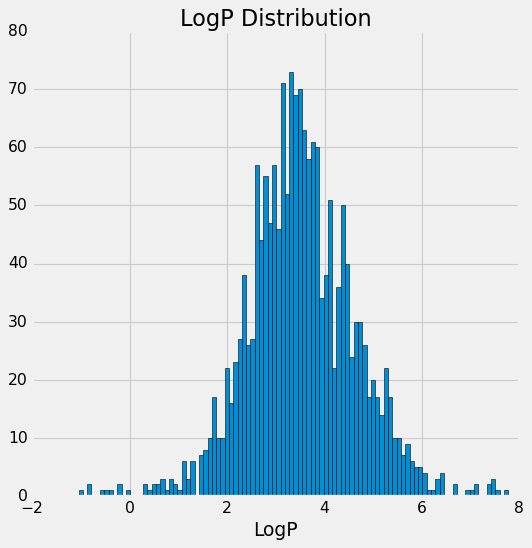

In [285]:
plt.style.use("fivethirtyeight")
plt.hist(df['logP'].dropna(), bins=100, edgecolor="k")
plt.xlabel("LogP")
plt.title("LogP Distribution")

Text(0.5, 1.0, 'AdrA1A_PCHEMBL_VALUE Distribution')

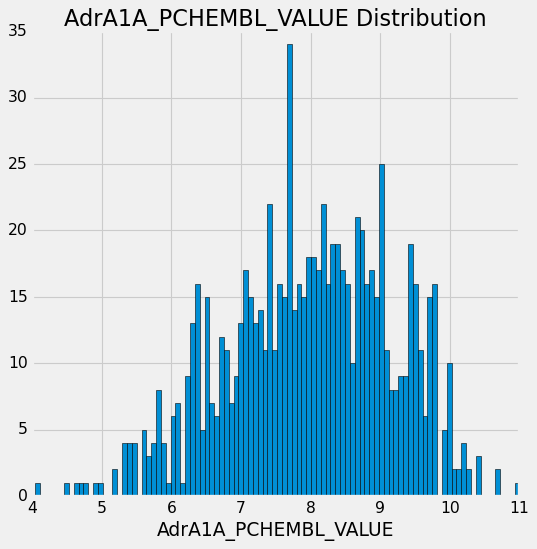

In [286]:
plt.style.use("fivethirtyeight")
plt.hist(df["AdrA1A_PCHEMBL_VALUE"].dropna(), bins=100, edgecolor="k")
plt.xlabel("AdrA1A_PCHEMBL_VALUE")
plt.title("AdrA1A_PCHEMBL_VALUE Distribution")

# "logP" as target value to predict

## Random forest

In [352]:
df1 = df.loc[df.logP.notnull()]
df1.shape

(1731, 328)

In [353]:
labels = [x for x in list(df1["logP"])]


In [354]:
X_features = list(df1["fp"])

In [355]:
X_train, X_test, y_train, y_test = train_test_split(X_features, labels, test_size=0.2, random_state=42)

In [356]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)

In [357]:
rf_model = rf.fit(X_train, y_train)

Text(0.5, 1.0, 'Actual vs. Predicted Values')

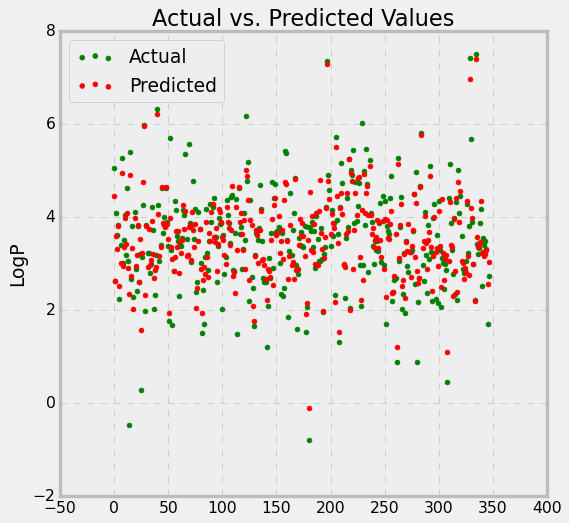

In [358]:
y_pred = rf_model.predict(X_test)

plt.style.use('bmh')
plt.rcParams["figure.figsize"] = (7,7)
plt.scatter(range(len(X_test)), y_test, color = "green")
plt.scatter(range(len(X_test)), y_pred, color = "red")
plt.ylabel("LogP")
plt.legend(['Actual', 'Predicted'], loc='upper left')
plt.title("Actual vs. Predicted Values")

Text(0.5, 1.0, 'Residuals')

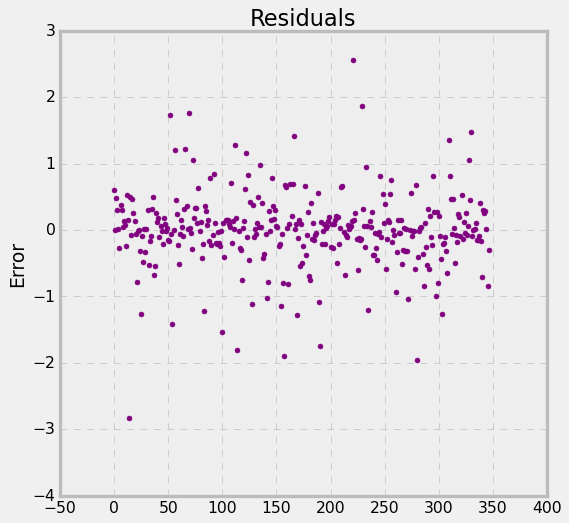

In [359]:
y_pred = rf_model.predict(X_test)

x = range(len(X_test))
y = [(x - y_pred[i]) for i, x in enumerate(y_test)]

plt.style.use('bmh')
plt.rcParams["figure.figsize"] = (7,7)
plt.scatter(x, y, color = "purple")
plt.ylabel("Error")
plt.title("Residuals")

In [360]:
rf_model.score(X_test, y_test)

0.7408732562399079

## SVR

In [361]:
from sklearn.svm import SVR

sv = SVR()
sv_model = sv.fit(X_train, y_train)

In [362]:
sv_model.score(X_test, y_test)

0.7198018056405777

# AdrA1A_PCHEMBL_VALUE as target value to predict

In [363]:
df2 = df.loc[df.AdrA1A_PCHEMBL_VALUE.notnull()]

In [364]:
X_features = list(df2["fp"])

In [365]:
labels = [x for x in list(df2["AdrA1A_PCHEMBL_VALUE"])]

In [366]:
X_train, X_test, y_train, y_test = train_test_split(X_features, labels, test_size=0.2, random_state=42)

In [276]:
rf = RandomForestRegressor()
param = {'n_estimators': [10, 150, 300],
        'max_depth': [20, 30, 40, None]}

gs = GridSearchCV(rf, param, cv=5, n_jobs=-1)
gs_fit = gs.fit(X_train, y_train)
pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,34.465603,4.119301,0.057275,0.010298,20,300,"{'max_depth': 20, 'n_estimators': 300}",0.485315,0.547271,0.537924,0.297200,0.514859,0.476514,0.092173,1
11,25.686673,1.828635,0.038752,0.005436,None,300,"{'max_depth': None, 'n_estimators': 300}",0.472727,0.546704,0.537266,0.302583,0.515496,0.474955,0.089879,2
8,32.135166,3.084706,0.049723,0.013897,40,300,"{'max_depth': 40, 'n_estimators': 300}",0.476663,0.547068,0.536475,0.299589,0.507640,0.473487,0.090331,3
5,33.185317,3.138171,0.051130,0.006740,30,300,"{'max_depth': 30, 'n_estimators': 300}",0.469686,0.543734,0.535952,0.285508,0.509382,0.468852,0.095255,4
4,16.222666,2.348824,0.026409,0.006002,30,150,"{'max_depth': 30, 'n_estimators': 150}",0.455776,0.537724,0.539324,0.289628,0.514326,0.467356,0.093871,5


In [367]:
rf = RandomForestRegressor(n_estimators=300, max_depth=20, n_jobs=-1)

In [368]:
rf_model = rf.fit(X_train, y_train)

In [369]:
rf_model.score(X_test, y_test)

0.49450005545089426

## GBoost

In [370]:
labels = df2["AdrA1A_PCHEMBL_VALUE"]

In [371]:
X_train, X_test, y_train, y_test = train_test_split(X_features, labels, test_size=0.2, random_state=42)

In [372]:
gb = GradientBoostingRegressor(n_estimators=150, learning_rate=0.1, max_depth=3)

In [373]:
gb_model = gb.fit(X_train, y_train)

Text(0.5, 1.0, 'Actual vs. Predicted Values')

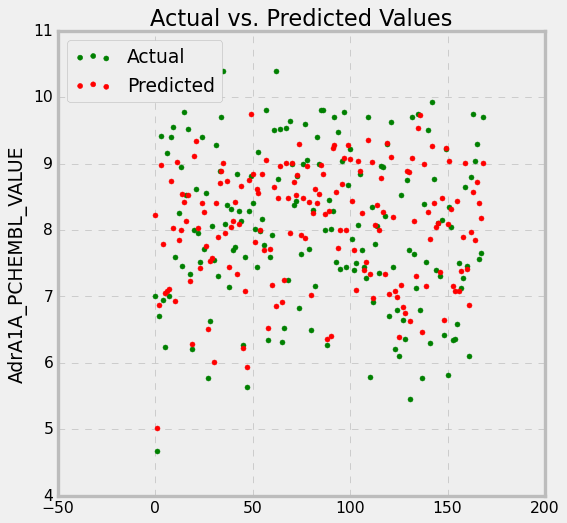

In [374]:
y_pred = gb_model.predict(X_test)


plt.style.use('bmh')
plt.rcParams["figure.figsize"] = (7,7)
plt.scatter(range(len(X_test)), y_test, color = "green")
plt.scatter(range(len(X_test)), y_pred, color = "red")
plt.ylabel("AdrA1A_PCHEMBL_VALUE")
plt.legend(['Actual', 'Predicted'], loc='upper left')
plt.title("Actual vs. Predicted Values")

Text(0.5, 1.0, 'Residuals')

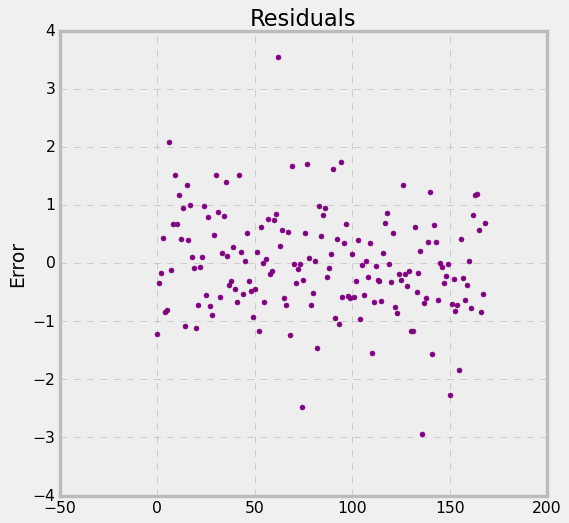

In [375]:
y_pred = gb_model.predict(X_test)

x = range(len(X_test))
y = [(x - y_pred[i]) for i, x in enumerate(y_test)]

plt.style.use('bmh')
plt.rcParams["figure.figsize"] = (7,7)
plt.scatter(x, y, color = "purple")
plt.ylabel("Error")
plt.title("Residuals")

In [376]:
gb_model.score(X_test, y_test)

0.4643904292060973

In [247]:
def train_GB(est, max_depth, lr):
    gb = GradientBoostingRegressor(n_estimators=est, learning_rate=lr, max_depth= max_depth)
    gb_model = gb.fit(X_train, y_train)
    scr = gb_model.score(X_test, y_test)
    print(f"Est: {est}, Max depth: {max_depth}, Learning rate: {lr} ---- Score: {scr}")

In [189]:
for n_est in [50, 100, 150]:
    for max_depth in [3, 7, 11, 15]:
        for lr in [0.01, 0.1, 1]:
            train_GB(n_est, max_depth, lr)

Est: 50, Max depth: 3, Learning rate: 0.01 ---- Score: 0.22877872726300508
Est: 50, Max depth: 3, Learning rate: 0.1 ---- Score: 0.44886450616788187
Est: 50, Max depth: 3, Learning rate: 1 ---- Score: 0.39903866909912544
Est: 50, Max depth: 7, Learning rate: 0.01 ---- Score: 0.2892945036760083
Est: 50, Max depth: 7, Learning rate: 0.1 ---- Score: 0.4860789042717497
Est: 50, Max depth: 7, Learning rate: 1 ---- Score: 0.09212287997250679
Est: 50, Max depth: 11, Learning rate: 0.01 ---- Score: 0.2716388362706892
Est: 50, Max depth: 11, Learning rate: 0.1 ---- Score: 0.23591799088794296
Est: 50, Max depth: 11, Learning rate: 1 ---- Score: 0.2145162614928119
Est: 50, Max depth: 15, Learning rate: 0.01 ---- Score: 0.2721241346993901
Est: 50, Max depth: 15, Learning rate: 0.1 ---- Score: 0.1697406874794909
Est: 50, Max depth: 15, Learning rate: 1 ---- Score: 0.14846212035810025
Est: 100, Max depth: 3, Learning rate: 0.01 ---- Score: 0.328189211908387
Est: 100, Max depth: 3, Learning rate: 0.1